<h1>Relatório: Aprendizado de máquina e reconhecimento de padrões</h1>
<h3>Aluno: André de Sousa Araújo</h3>
<p>Objetivo principal é estimar a ocorrências de precipações extremas.</p>
<p>Espaço: Região HOUSTON - Texas</p>
<p><b>Base escolhida:</b>
This public dataset was created by the National Oceanic and Atmospheric Administration (NOAA) and includes global data obtained from the USAF Climatology Center.  This dataset covers GSOD data between 1929 and present, collected from over 9000 stations.
</p>
<p>Dataset Source: NOAA</p>

<p>Category: Weather</p>

<p>Use: This dataset is publicly available for anyone to use under the following terms provided by the Dataset Source — http://www.data.gov/privacy-policy#data_policy — and is provided "AS IS" without any warranty, express or implied, from Google. Google disclaims all liability for any damages, direct or indirect, resulting from the use of the dataset.</p>

<p>Update Frequency: daily</p>

<h2 style="color:blue;">Importando o dataset e explorando os dados</h2>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [14]:
import seaborn as sns
import pandas as pd
import numpy as np
import shutil
from sklearn.utils import shuffle
import matplotlib.pyplot as plt  

<h2 style="color:blue;">Importando o dataset para treinamento e validação</h2>

<p>Vamos selecionar para treinamento e validação os meses de agosto de 1985 até 2015 desta região.</p>

In [3]:
df = pd.read_csv('../data/prpc-all-data.csv',low_memory=False)
print len(df)

5417782


In [121]:
df = df[(df['ws_lat'] >= 28.75510204)]
df = df[(df['ws_lat'] <= 29.69387755)]
df = df[(df['ws_lon'] <= -94.69798658)]
df = df[(df['ws_lon'] >= -96.28187919)]
print len(df)
df[:10]

23476


,d_stn,ws_lat,ws_lon,d_da,d_mo,d_year,d_temp,d_dewp,d_slp,d_stp,...,d_min,d_prcp,d_flag_prcp,d_sndp,d_fog,d_rain_drizzle,d_snow_ice_pellets,d_hail,d_thunder,d_tornado_funnel_cloud
9908,722427,29.517,-95.25,3,8,2001,83.2,72.8,1017.7,9999.9,...,75.0,0.29,G,999.9,0,0,0,0,0,0
9909,722427,29.517,-95.25,12,6,2004,83.3,74.6,1014.9,9999.9,...,77.0,0.00,I,999.9,0,0,0,0,0,0
9910,722427,29.517,-95.25,17,6,2003,77.2,71.7,1013.4,9999.9,...,69.1,0.00,A,999.9,0,0,0,0,1,0
9911,722427,29.517,-95.25,11,8,2004,83.5,73.6,1013.8,9999.9,...,75.9,0.00,B,999.9,0,0,0,0,1,0
9912,722427,29.517,-95.25,30,7,2004,83.7,76.1,1011.2,9999.9,...,75.9,0.00,I,999.9,0,0,0,0,1,0
9913,722427,29.517,-95.25,20,8,2004,85.5,75.9,1015.8,9999.9,...,79.0,0.00,A,999.9,0,0,0,0,0,0
9914,722427,29.517,-95.25,25,8,2004,84.7,76.2,1015.6,9999.9,...,75.9,0.00,I,999.9,0,0,0,0,0,0
9915,722427,29.517,-95.25,21,6,2002,82.2,72.6,1021.4,9999.9,...,73.4,0.00,I,999.9,0,0,0,0,1,0
9916,722427,29.517,-95.25,24,8,2002,82.1,74.7,1016.5,9999.9,...,73.9,0.00,A,999.9,0,0,0,0,1,0
9917,722427,29.517,-95.25,2,8,2002,82.7,72.5,1015.7,9999.9,...,73.0,0.00,G,999.9,0,0,0,0,0,0


<h2 style="color:blue;">Feature engineering</h2>

<p>O objetivo é realizar a previsão destes eventos usando as variáveis de 3 dias atrás. No estudo de Dolif Neto e Nobre (2012) foram extraídas variavéis também de 3 dias atrás dos fenômenos precipitações extremas. Assim vamos derivar as variáveis de 3 dias atrás antes do fenômeno. Inicialente <b>vamos derivar somente a precipitação</b>, testar e depois fazer para todas as varíaveis</p>

In [122]:
prcp30_limpo = prcp30_limpo.apply(pd.to_numeric, errors='coerce')  

tmp = prcp30_limpo[['d_stn','d_da','d_mo','d_year','d_prcp']]
tmp = tmp.sort_values(['d_year','d_stn','d_da'])
tmp = tmp.reset_index(drop=True)



In [123]:
prcp30_limpo = df[df['d_prcp']< 99.99]
prcp30_limpo = prcp30_limpo.apply(pd.to_numeric, errors='coerce')  

tmp = prcp30_limpo[['d_stn','d_da','d_mo','d_year','d_prcp']]
tmp = tmp.sort_values(['d_year','d_stn','d_da'])
tmp = tmp.reset_index(drop=True)

In [124]:
N = 1 #1 dia antes
feature = 'd_prcp'

nth_prior =[]

# Devirando a variavel para uma lista representando a enesima valor da variavel, se for o primeiro dia não terá dia anterior.
for y in range(1985,2018):
  df_year = tmp[tmp['d_year']== y]
  df_year = df_year.reset_index(drop=True)
  rows = df_year.shape[0]
  prior= [None]*N + [df_year[feature][i-N] for i in range(N, rows)]
  nth_prior = nth_prior + prior
  
col_name = "{}_{}".format(feature, N)  
tmp[col_name] = nth_prior  
tmp[:10]   

,d_stn,d_da,d_mo,d_year,d_prcp,d_prcp_1
0,722420,1,7,1985,0.0,NaN
1,722420,1,8,1985,0.0,0.0
2,722420,1,6,1985,0.0,0.0
3,722420,2,6,1985,0.0,0.0
4,722420,2,7,1985,0.0,0.0
5,722420,2,8,1985,0.0,0.0
6,722420,3,6,1985,0.0,0.0
7,722420,3,8,1985,0.0,0.0
8,722420,3,7,1985,0.0,0.0
9,722420,4,8,1985,0.0,0.0


<p>Veja que para a estação ID 722430 no dia 4/8/1985, a precipitação do dia anterior (d_prcp_1) é exatamente o valor medido no dia 03/08/1985. Agora vamos fazer isto para todas as variaveis.</p>

In [125]:
def derivar_valor_anterior(df, dias, variavel):
  N = dias
  feature = variavel
  tmp = df

  nth_prior =[]

  # Devirando a variavel para uma lista representando a enesima valor da variavel, se for o primeiro dia não terá dia anterior.
  for y in range(1985,2018):
    df_year = tmp[tmp['d_year']== y]
    df_year = df_year.reset_index(drop=True)
    rows = df_year.shape[0]
    prior= [None]*N + [df_year[feature][i-N] for i in range(N, rows)]
    nth_prior = nth_prior + prior

  col_name = "{}_{}".format(feature, N)  
  tmp[col_name] = nth_prior


df_dev = df.apply(pd.to_numeric, errors='coerce')  
df_dev = df_dev.sort_values(['d_year','d_stn','d_da'])
df_dev = df_dev.reset_index(drop=True)
  
for var in list(df_dev):
  if var not in ['d_stn','d_da','d_mo','d_year','ws_lat','ws_lon']:
    for N in range(1, 4):
      derivar_valor_anterior(df_dev,N,var)

df_dev.columns 

Index([u'd_stn', u'ws_lat', u'ws_lon', u'd_da', u'd_mo', u'd_year', u'd_temp',
       u'd_dewp', u'd_slp', u'd_stp', u'd_visib', u'd_wdsp', u'd_mxpsd',
       u'd_gust', u'd_max', u'd_min', u'd_prcp', u'd_flag_prcp', u'd_sndp',
       u'd_fog', u'd_rain_drizzle', u'd_snow_ice_pellets', u'd_hail',
       u'd_thunder', u'd_tornado_funnel_cloud', u'd_temp_1', u'd_temp_2',
       u'd_temp_3', u'd_dewp_1', u'd_dewp_2', u'd_dewp_3', u'd_slp_1',
       u'd_slp_2', u'd_slp_3', u'd_stp_1', u'd_stp_2', u'd_stp_3',
       u'd_visib_1', u'd_visib_2', u'd_visib_3', u'd_wdsp_1', u'd_wdsp_2',
       u'd_wdsp_3', u'd_mxpsd_1', u'd_mxpsd_2', u'd_mxpsd_3', u'd_gust_1',
       u'd_gust_2', u'd_gust_3', u'd_max_1', u'd_max_2', u'd_max_3',
       u'd_min_1', u'd_min_2', u'd_min_3', u'd_prcp_1', u'd_prcp_2',
       u'd_prcp_3', u'd_flag_prcp_1', u'd_flag_prcp_2', u'd_flag_prcp_3',
       u'd_sndp_1', u'd_sndp_2', u'd_sndp_3', u'd_fog_1', u'd_fog_2',
       u'd_fog_3', u'd_rain_drizzle_1', u'd_rain_drizzle_2

<p>Pronto! Agora temos variaveis respectivas de 1, 2, 3 dias atrás. Exemplo: d_prcp_1, d_prcp_2, d_prcp_3 referentes a precipitação 1, 2 e 3 dias atrás respectivamente.</p>

<h2 style="color:blue;">Limpeza dos dados</h2>

<p>Conforme dito anteriormente, existem muitos dados ausentes para algumas variáveis. Podemos excluir as instâncias, mas precisamos ver se perderíamos muitos dados</p>

In [126]:
df_dev = df_dev.apply(pd.to_numeric, errors='coerce')  
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23476 entries, 0 to 23475
Data columns (total 82 columns):
d_stn                       23476 non-null int64
ws_lat                      23476 non-null float64
ws_lon                      23476 non-null float64
d_da                        23476 non-null int64
d_mo                        23476 non-null int64
d_year                      23476 non-null int64
d_temp                      23476 non-null float64
d_dewp                      23476 non-null float64
d_slp                       23476 non-null float64
d_stp                       23476 non-null float64
d_visib                     23476 non-null float64
d_wdsp                      23476 non-null float64
d_mxpsd                     23476 non-null float64
d_gust                      23476 non-null float64
d_max                       23476 non-null float64
d_min                       23476 non-null float64
d_prcp                      23476 non-null float64
d_flag_prcp                 0 no

In [127]:
df_dev[:10]

,d_stn,ws_lat,ws_lon,d_da,d_mo,d_year,d_temp,d_dewp,d_slp,d_stp,...,d_snow_ice_pellets_3,d_hail_1,d_hail_2,d_hail_3,d_thunder_1,d_thunder_2,d_thunder_3,d_tornado_funnel_cloud_1,d_tornado_funnel_cloud_2,d_tornado_funnel_cloud_3
0,722420,29.3,-94.8,1,7,1985,80.7,63.3,1019.8,1017.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,722420,29.3,-94.8,1,8,1985,83.4,72.1,1017.2,1015.2,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
2,722420,29.3,-94.8,1,6,1985,78.0,70.2,1014.3,1012.3,...,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
3,722420,29.3,-94.8,2,6,1985,78.6,69.8,1014.2,1012.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,722420,29.3,-94.8,2,7,1985,81.1,69.6,1020.7,1018.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,722420,29.3,-94.8,2,8,1985,83.5,72.6,1015.0,1013.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,722420,29.3,-94.8,3,6,1985,79.3,70.2,1014.6,1012.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,722420,29.3,-94.8,3,8,1985,81.6,72.3,1014.8,1012.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,722420,29.3,-94.8,3,7,1985,80.5,68.6,1019.4,1017.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,722420,29.3,-94.8,4,8,1985,83.3,72.3,1014.9,1012.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
df_temp = df_dev[(df_dev < 9999.9000).all(axis=1)]
print ('Tamanho antes da limpeza: %s' %str(len(df_dev))) 
print ('Tamanho depois da limpeza: %s' %str(len(df_temp))) 

Tamanho antes da limpeza: 23476
Tamanho depois da limpeza: 0


<p>A conclusão é que todo registro tem algum dado ausente. Assim vamos verificar se tem alguma variável que apresenta maiores problemas.<p/>

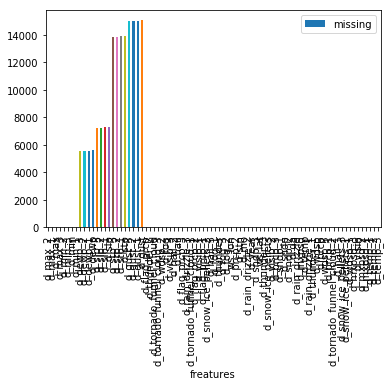

In [129]:
def contabilizar_dados_ausentes(df):
  dn = {}
  
  for v in df.columns:
    df_grp = df[df[v] == 9999.9]
    dn[v] = len(df_grp)

  for v in ['d_gust','d_gust_1', 'd_gust_2', 'd_gust_3']:
    if v in df.columns:
      df_grp = df[df[v] == 999.9]
      dn[v] = dn[v] + len(df_grp)

  for v in ['d_prcp','d_prcp_1', 'd_prcp_2', 'd_prcp_3']:
    if v in df.columns:
      df_grp = df[df[v] == 99.9]
      dn[v] = dn[v] + len(df_grp) 
    
  pdn = pd.DataFrame(dn.items(), columns=['freatures', 'missing'])
  pdn = pdn[pdn > 0]
  pdn = pdn.sort_values(['missing'])
  
  return pdn

pdn = contabilizar_dados_ausentes(df_dev)
pdn.plot.bar(x='freatures', y='missing')
plt.show()

<p> As varíveis velocidade máxima do vento do dia (d_mxpsd), velocidade do fenômeno de aumento repentino do vento (d_gust), média da velocidade do vento (d_wdsp), temperatura do ponto de orvaloho (d_dewp) e pressão atmosferica (d_stp) apresentam valores nulos significativos. Sendo a variável d_gust a mais problemática.</p>

<p>A decisão será remover velocidade do fenômeno de aumento repentino do vento (d_gust) e  pressão atmosferica (d_stp). E interpolar as demais utilizando algum método.</p>

In [130]:
df_limpo = df_dev.copy(deep=True)

for column in df_limpo.columns:
    if column in ['d_gust','d_gust_1','d_gust_2','d_gust_3']:
        df_limpo = df_limpo.drop(column, axis = 1)
        
for column in df_limpo.columns:
    if column in ['d_stp','d_stp_1','d_stp_2','d_stp_3']:
        df_limpo = df_limpo.drop(column, axis = 1)
        
for column in df_limpo.columns:
    if column in ['d_flag_prcp','d_flag_prcp_1','d_flag_prcp_2','d_flag_prcp_3']:
        df_limpo = df_limpo.drop(column, axis = 1)
        
for column in df_limpo.columns:
    if column in ['d_sndp','d_sndp_1','d_sndp_2','d_sndp_3']:
        df_limpo = df_limpo.drop(column, axis = 1)
        
for column in df_limpo.columns:
    if column in ['key','key_1','key_2','key_3']:
        df_limpo = df_limpo.drop(column, axis = 1)

df_limpo.columns

Index([u'd_stn', u'ws_lat', u'ws_lon', u'd_da', u'd_mo', u'd_year', u'd_temp',
       u'd_dewp', u'd_slp', u'd_visib', u'd_wdsp', u'd_mxpsd', u'd_max',
       u'd_min', u'd_prcp', u'd_fog', u'd_rain_drizzle', u'd_snow_ice_pellets',
       u'd_hail', u'd_thunder', u'd_tornado_funnel_cloud', u'd_temp_1',
       u'd_temp_2', u'd_temp_3', u'd_dewp_1', u'd_dewp_2', u'd_dewp_3',
       u'd_slp_1', u'd_slp_2', u'd_slp_3', u'd_visib_1', u'd_visib_2',
       u'd_visib_3', u'd_wdsp_1', u'd_wdsp_2', u'd_wdsp_3', u'd_mxpsd_1',
       u'd_mxpsd_2', u'd_mxpsd_3', u'd_max_1', u'd_max_2', u'd_max_3',
       u'd_min_1', u'd_min_2', u'd_min_3', u'd_prcp_1', u'd_prcp_2',
       u'd_prcp_3', u'd_fog_1', u'd_fog_2', u'd_fog_3', u'd_rain_drizzle_1',
       u'd_rain_drizzle_2', u'd_rain_drizzle_3', u'd_snow_ice_pellets_1',
       u'd_snow_ice_pellets_2', u'd_snow_ice_pellets_3', u'd_hail_1',
       u'd_hail_2', u'd_hail_3', u'd_thunder_1', u'd_thunder_2',
       u'd_thunder_3', u'd_tornado_funnel_cloud_1',
 

<p>Agora temos outras varíaveis para tratar, que ainda estão afetando muitas instâncias</p>

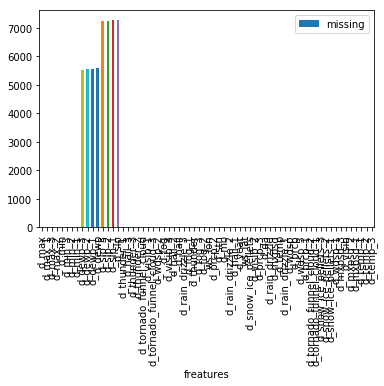

In [131]:
p = contabilizar_dados_ausentes(df_limpo)
p.plot.bar(x='freatures', y='missing')
plt.show()

<p>Primeiramente vamos marcar os dados ausentes.</p>

In [132]:
def marcar_dados_ausentes(df):
  for v in df.columns:
    df[v] = df[v].replace([9999.9],"NaN")
  for v in df.columns:
    df[v] = df[v].replace([999.9],"NaN")

marcar_dados_ausentes(df_limpo)

for v in df_limpo.columns:
  if v in ['d_prcp','d_prcp_1', 'd_prcp_2', 'd_prcp_3']:
    df_limpo[v] = df_limpo[v].replace([99.9],"NaN")

df_limpo = df_limpo.apply(pd.to_numeric, errors='coerce')  
df_limpo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23476 entries, 0 to 23475
Data columns (total 66 columns):
d_stn                       23476 non-null int64
ws_lat                      23476 non-null float64
ws_lon                      23476 non-null float64
d_da                        23476 non-null int64
d_mo                        23476 non-null int64
d_year                      23476 non-null int64
d_temp                      23476 non-null float64
d_dewp                      17886 non-null float64
d_slp                       16207 non-null float64
d_visib                     17830 non-null float64
d_wdsp                      23139 non-null float64
d_mxpsd                     22608 non-null float64
d_max                       23473 non-null float64
d_min                       23470 non-null float64
d_prcp                      23476 non-null float64
d_fog                       23476 non-null int64
d_rain_drizzle              23476 non-null int64
d_snow_ice_pellets          23476 no

<p>Interpolá-los</p>

<h2 style="color:blue;">Interpolandos dados para outras variáveis: dados ausentes</h2>

In [133]:
df_intptd = df_limpo.copy(deep=True)
for v in df_intptd:
  if v not in ['d_stn','d_da','d_mo','d_year']:
    df_intptd[v] = df_intptd[v].astype(float)

df_intptd = df_intptd.interpolate(method='linear', axis=0).ffill().bfill()
df_intptd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23476 entries, 0 to 23475
Data columns (total 66 columns):
d_stn                       23476 non-null int64
ws_lat                      23476 non-null float64
ws_lon                      23476 non-null float64
d_da                        23476 non-null int64
d_mo                        23476 non-null int64
d_year                      23476 non-null int64
d_temp                      23476 non-null float64
d_dewp                      23476 non-null float64
d_slp                       23476 non-null float64
d_visib                     23476 non-null float64
d_wdsp                      23476 non-null float64
d_mxpsd                     23476 non-null float64
d_max                       23476 non-null float64
d_min                       23476 non-null float64
d_prcp                      23476 non-null float64
d_fog                       23476 non-null float64
d_rain_drizzle              23476 non-null float64
d_snow_ice_pellets          2347

In [134]:
df_intptd[:10]

,d_stn,ws_lat,ws_lon,d_da,d_mo,d_year,d_temp,d_dewp,d_slp,d_visib,...,d_snow_ice_pellets_3,d_hail_1,d_hail_2,d_hail_3,d_thunder_1,d_thunder_2,d_thunder_3,d_tornado_funnel_cloud_1,d_tornado_funnel_cloud_2,d_tornado_funnel_cloud_3
0,722420,29.3,-94.8,1,7,1985,80.7,63.3,1019.8,8.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,722420,29.3,-94.8,1,8,1985,83.4,72.1,1017.2,8.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,722420,29.3,-94.8,1,6,1985,78.0,70.2,1014.3,7.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,722420,29.3,-94.8,2,6,1985,78.6,69.8,1014.2,8.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,722420,29.3,-94.8,2,7,1985,81.1,69.6,1020.7,9.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,722420,29.3,-94.8,2,8,1985,83.5,72.6,1015.0,7.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,722420,29.3,-94.8,3,6,1985,79.3,70.2,1014.6,8.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,722420,29.3,-94.8,3,8,1985,81.6,72.3,1014.8,7.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,722420,29.3,-94.8,3,7,1985,80.5,68.6,1019.4,7.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,722420,29.3,-94.8,4,8,1985,83.3,72.3,1014.9,8.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h2 style="color:blue;">Pearson correlation coefficient</h2>

In [135]:
import seaborn as sns

In [136]:
FLAGS = ['d_fog','d_rain_drizzle','d_snow_ice_pellets','d_hail','d_thunder','d_tornado_funnel_cloud','d_fog_1','d_rain_drizzle_1','d_snow_ice_pellets_1','d_hail_1','d_thunder_1','d_tornado_funnel_cloud_1','d_fog_2','d_rain_drizzle_2','d_snow_ice_pellets_2','d_hail_2','d_thunder_2','d_tornado_funnel_cloud_2','d_fog_3','d_rain_drizzle_3','d_snow_ice_pellets_3','d_hail_3','d_thunder_3','d_tornado_funnel_cloud_3']
print (FLAGS) 

['d_fog', 'd_rain_drizzle', 'd_snow_ice_pellets', 'd_hail', 'd_thunder', 'd_tornado_funnel_cloud', 'd_fog_1', 'd_rain_drizzle_1', 'd_snow_ice_pellets_1', 'd_hail_1', 'd_thunder_1', 'd_tornado_funnel_cloud_1', 'd_fog_2', 'd_rain_drizzle_2', 'd_snow_ice_pellets_2', 'd_hail_2', 'd_thunder_2', 'd_tornado_funnel_cloud_2', 'd_fog_3', 'd_rain_drizzle_3', 'd_snow_ice_pellets_3', 'd_hail_3', 'd_thunder_3', 'd_tornado_funnel_cloud_3']


In [137]:
df_corl = df_intptd.copy(deep=True)
for v in df_corl.columns:
  if v in ['d_stn','d_da','d_mo','d_year', 'ws_lat', 'ws_lon']:
    df_corl = df_corl.drop(v, axis = 1)
    
for v in df_corl.columns:
  if v in FLAGS:
    df_corl = df_corl.drop(v, axis = 1)

df_corl[:10]

,d_temp,d_dewp,d_slp,d_visib,d_wdsp,d_mxpsd,d_max,d_min,d_prcp,d_temp_1,...,d_mxpsd_3,d_max_1,d_max_2,d_max_3,d_min_1,d_min_2,d_min_3,d_prcp_1,d_prcp_2,d_prcp_3
0,80.7,63.3,1019.8,8.4,8.5,11.1,85.6,74.7,0.0,80.7,...,11.1,85.6,85.6,85.6,74.7,74.7,74.7,0.0,0.0,0.0
1,83.4,72.1,1017.2,8.4,8.3,11.1,88.2,79.7,0.0,80.7,...,11.1,85.6,85.6,85.6,74.7,74.7,74.7,0.0,0.0,0.0
2,78.0,70.2,1014.3,7.6,9.7,12.0,82.0,75.7,0.0,83.4,...,11.1,88.2,85.6,85.6,79.7,74.7,74.7,0.0,0.0,0.0
3,78.6,69.8,1014.2,8.4,10.7,12.0,81.9,75.7,0.0,78.0,...,11.1,82.0,88.2,85.6,75.7,79.7,74.7,0.0,0.0,0.0
4,81.1,69.6,1020.7,9.2,10.8,12.0,83.5,78.1,0.0,78.6,...,11.1,81.9,82.0,88.2,75.7,75.7,79.7,0.0,0.0,0.0
5,83.5,72.6,1015.0,7.6,8.2,9.9,88.2,79.3,0.0,81.1,...,12.0,83.5,81.9,82.0,78.1,75.7,75.7,0.0,0.0,0.0
6,79.3,70.2,1014.6,8.4,9.7,11.1,82.0,76.3,0.0,83.5,...,12.0,88.2,83.5,81.9,79.3,78.1,75.7,0.0,0.0,0.0
7,81.6,72.3,1014.8,7.6,8.3,13.0,92.1,76.8,0.0,79.3,...,12.0,82.0,88.2,83.5,76.3,79.3,78.1,0.0,0.0,0.0
8,80.5,68.6,1019.4,7.6,9.0,14.0,83.8,78.4,0.0,81.6,...,9.9,92.1,82.0,88.2,76.8,76.3,79.3,0.0,0.0,0.0
9,83.3,72.3,1014.9,8.4,8.4,9.9,87.3,76.8,0.0,80.5,...,11.1,83.8,92.1,82.0,78.4,76.8,76.3,0.0,0.0,0.0


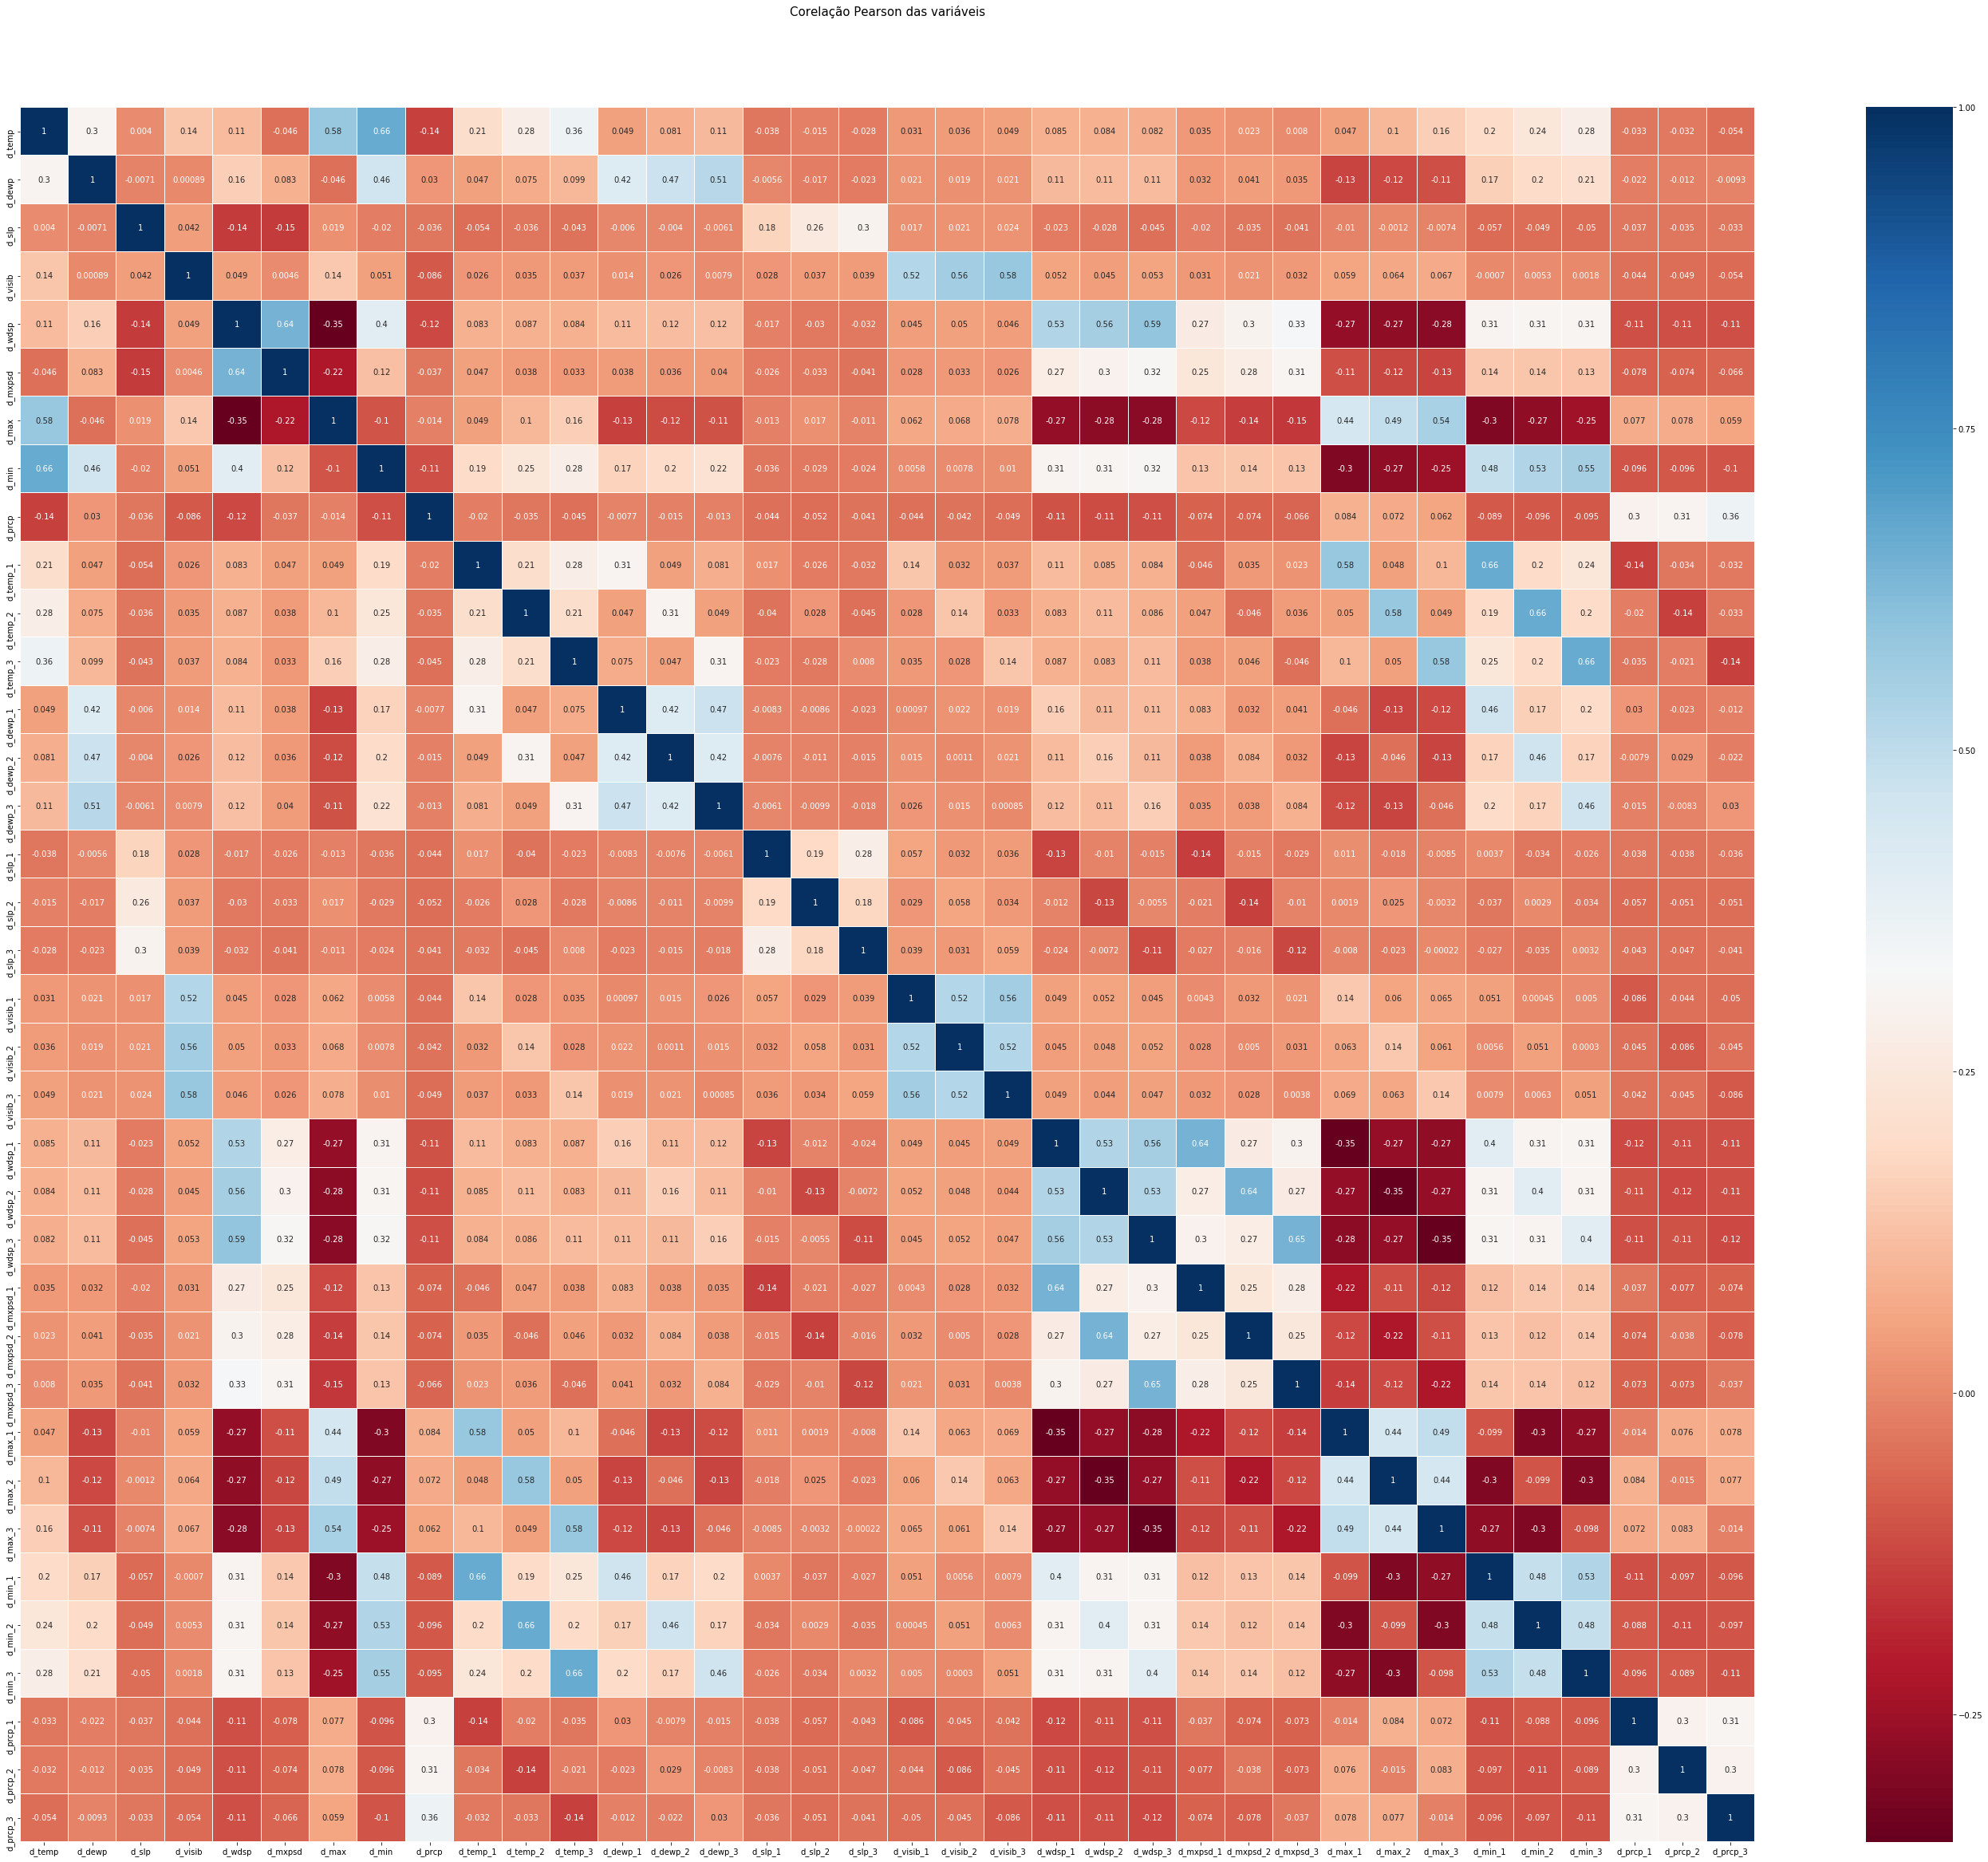

In [138]:
colormap = plt.cm.RdBu
plt.figure(figsize=(50,40))
plt.title(u'Corelação Pearson das variáveis', y=1.05, size=15)
svm = sns.heatmap(df_corl.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

fig = svm.get_figure()
name = '../graphs/pearson-all.png'
fig.savefig(name,dpi=200)

#df_corl.corr()[['d_prcp']].sort_values('d_prcp')  

<p>Nenhuma variável apresentou uma correlação alta. Assim vamos aplicar um modelo não linear.</p>

In [139]:
for v in df_corl.columns:
  if '_1' in v:  
    df_corl = df_corl.drop(v, axis = 1)
  if '_2' in v:  
    df_corl = df_corl.drop(v, axis = 1)
  if '_3' in v:  
    df_corl = df_corl.drop(v, axis = 1)
    
    
for v in df_corl.columns:
  if v in FLAGS:
    df_corl = df_corl.drop(v, axis = 1)

df_corl[:10]

,d_temp,d_dewp,d_slp,d_visib,d_wdsp,d_mxpsd,d_max,d_min,d_prcp
0,80.7,63.3,1019.8,8.4,8.5,11.1,85.6,74.7,0.0
1,83.4,72.1,1017.2,8.4,8.3,11.1,88.2,79.7,0.0
2,78.0,70.2,1014.3,7.6,9.7,12.0,82.0,75.7,0.0
3,78.6,69.8,1014.2,8.4,10.7,12.0,81.9,75.7,0.0
4,81.1,69.6,1020.7,9.2,10.8,12.0,83.5,78.1,0.0
5,83.5,72.6,1015.0,7.6,8.2,9.9,88.2,79.3,0.0
6,79.3,70.2,1014.6,8.4,9.7,11.1,82.0,76.3,0.0
7,81.6,72.3,1014.8,7.6,8.3,13.0,92.1,76.8,0.0
8,80.5,68.6,1019.4,7.6,9.0,14.0,83.8,78.4,0.0
9,83.3,72.3,1014.9,8.4,8.4,9.9,87.3,76.8,0.0


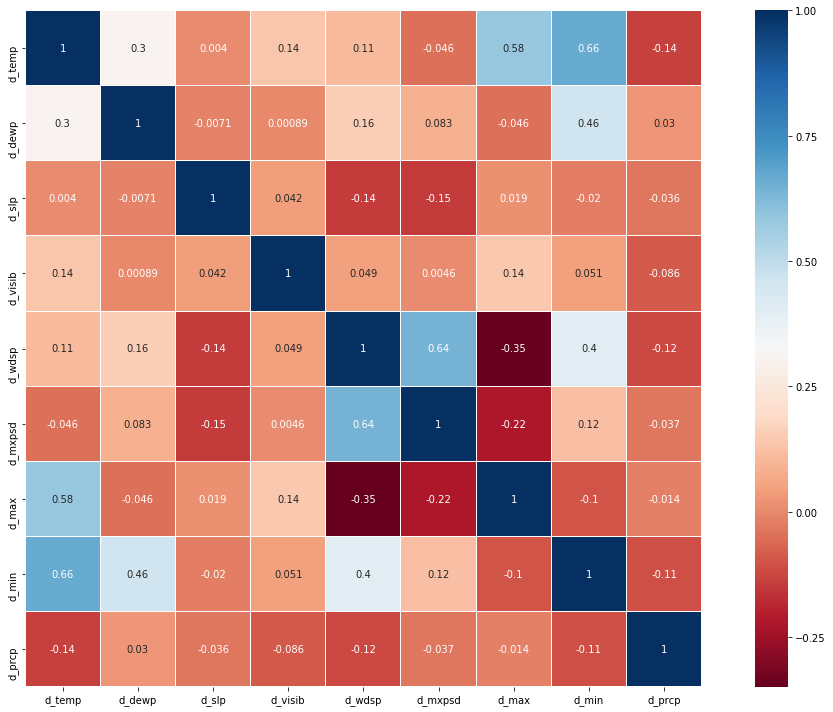

In [140]:
colormap = plt.cm.RdBu
plt.figure(figsize=(15,10))
#plt.title(u'Correlação Pearson das variáveis base', size=15)
svm = sns.heatmap(df_corl.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
fig = svm.get_figure()
fig.tight_layout()
name = '../graphs/pearson-base.png'
fig.savefig(name,dpi=200)

<h2 style="color:blue;">Treinamento e validação</h2>

In [141]:
df_intptd[:10]

,d_stn,ws_lat,ws_lon,d_da,d_mo,d_year,d_temp,d_dewp,d_slp,d_visib,...,d_snow_ice_pellets_3,d_hail_1,d_hail_2,d_hail_3,d_thunder_1,d_thunder_2,d_thunder_3,d_tornado_funnel_cloud_1,d_tornado_funnel_cloud_2,d_tornado_funnel_cloud_3
0,722420,29.3,-94.8,1,7,1985,80.7,63.3,1019.8,8.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,722420,29.3,-94.8,1,8,1985,83.4,72.1,1017.2,8.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,722420,29.3,-94.8,1,6,1985,78.0,70.2,1014.3,7.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,722420,29.3,-94.8,2,6,1985,78.6,69.8,1014.2,8.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,722420,29.3,-94.8,2,7,1985,81.1,69.6,1020.7,9.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,722420,29.3,-94.8,2,8,1985,83.5,72.6,1015.0,7.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,722420,29.3,-94.8,3,6,1985,79.3,70.2,1014.6,8.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,722420,29.3,-94.8,3,8,1985,81.6,72.3,1014.8,7.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,722420,29.3,-94.8,3,7,1985,80.5,68.6,1019.4,7.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,722420,29.3,-94.8,4,8,1985,83.3,72.3,1014.9,8.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [142]:
df_intptd[:10]

,d_stn,ws_lat,ws_lon,d_da,d_mo,d_year,d_temp,d_dewp,d_slp,d_visib,...,d_snow_ice_pellets_3,d_hail_1,d_hail_2,d_hail_3,d_thunder_1,d_thunder_2,d_thunder_3,d_tornado_funnel_cloud_1,d_tornado_funnel_cloud_2,d_tornado_funnel_cloud_3
0,722420,29.3,-94.8,1,7,1985,80.7,63.3,1019.8,8.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,722420,29.3,-94.8,1,8,1985,83.4,72.1,1017.2,8.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,722420,29.3,-94.8,1,6,1985,78.0,70.2,1014.3,7.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,722420,29.3,-94.8,2,6,1985,78.6,69.8,1014.2,8.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,722420,29.3,-94.8,2,7,1985,81.1,69.6,1020.7,9.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,722420,29.3,-94.8,2,8,1985,83.5,72.6,1015.0,7.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,722420,29.3,-94.8,3,6,1985,79.3,70.2,1014.6,8.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,722420,29.3,-94.8,3,8,1985,81.6,72.3,1014.8,7.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,722420,29.3,-94.8,3,7,1985,80.5,68.6,1019.4,7.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,722420,29.3,-94.8,4,8,1985,83.3,72.3,1014.9,8.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:
TRAIN_SIZE = int(0.7*len(df_intptd))
DF_TRAIN = df_intptd[:TRAIN_SIZE]
DF_TEST = df_intptd[TRAIN_SIZE:]

In [144]:
print len(DF_TRAIN)
print len(DF_TEST)

16433
7043


In [145]:
#removendo colunas inuteis para o modelo
for v in df_intptd.columns:
  if v in ['d_da','d_mo']:
    df_intptd = df_intptd.drop(v, axis = 1)

In [146]:
import tensorflow as tf
import shutil

print tf.__version__
tf.logging.set_verbosity(tf.logging.INFO)

1.4.1


In [147]:
#variavel a ser prevista
TARGET = u'd_prcp'
cols = list(df_intptd)
cols.remove(TARGET)
cols.insert(0, TARGET)
df_intptd[:10]

,d_stn,ws_lat,ws_lon,d_year,d_temp,d_dewp,d_slp,d_visib,d_wdsp,d_mxpsd,...,d_snow_ice_pellets_3,d_hail_1,d_hail_2,d_hail_3,d_thunder_1,d_thunder_2,d_thunder_3,d_tornado_funnel_cloud_1,d_tornado_funnel_cloud_2,d_tornado_funnel_cloud_3
0,722420,29.3,-94.8,1985,80.7,63.3,1019.8,8.4,8.5,11.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,722420,29.3,-94.8,1985,83.4,72.1,1017.2,8.4,8.3,11.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,722420,29.3,-94.8,1985,78.0,70.2,1014.3,7.6,9.7,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,722420,29.3,-94.8,1985,78.6,69.8,1014.2,8.4,10.7,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,722420,29.3,-94.8,1985,81.1,69.6,1020.7,9.2,10.8,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,722420,29.3,-94.8,1985,83.5,72.6,1015.0,7.6,8.2,9.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,722420,29.3,-94.8,1985,79.3,70.2,1014.6,8.4,9.7,11.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,722420,29.3,-94.8,1985,81.6,72.3,1014.8,7.6,8.3,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,722420,29.3,-94.8,1985,80.5,68.6,1019.4,7.6,9.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,722420,29.3,-94.8,1985,83.3,72.3,1014.9,8.4,8.4,9.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
FEATURES = df_intptd.columns.tolist()
print FEATURES

['d_stn', 'ws_lat', 'ws_lon', 'd_year', 'd_temp', 'd_dewp', 'd_slp', 'd_visib', 'd_wdsp', 'd_mxpsd', 'd_max', 'd_min', 'd_prcp', 'd_fog', 'd_rain_drizzle', 'd_snow_ice_pellets', 'd_hail', 'd_thunder', 'd_tornado_funnel_cloud', 'd_temp_1', 'd_temp_2', 'd_temp_3', 'd_dewp_1', 'd_dewp_2', 'd_dewp_3', 'd_slp_1', 'd_slp_2', 'd_slp_3', 'd_visib_1', 'd_visib_2', 'd_visib_3', 'd_wdsp_1', 'd_wdsp_2', 'd_wdsp_3', 'd_mxpsd_1', 'd_mxpsd_2', 'd_mxpsd_3', 'd_max_1', 'd_max_2', 'd_max_3', 'd_min_1', 'd_min_2', 'd_min_3', 'd_prcp_1', 'd_prcp_2', 'd_prcp_3', 'd_fog_1', 'd_fog_2', 'd_fog_3', 'd_rain_drizzle_1', 'd_rain_drizzle_2', 'd_rain_drizzle_3', 'd_snow_ice_pellets_1', 'd_snow_ice_pellets_2', 'd_snow_ice_pellets_3', 'd_hail_1', 'd_hail_2', 'd_hail_3', 'd_thunder_1', 'd_thunder_2', 'd_thunder_3', 'd_tornado_funnel_cloud_1', 'd_tornado_funnel_cloud_2', 'd_tornado_funnel_cloud_3']


In [149]:
df_intptd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23476 entries, 0 to 23475
Data columns (total 64 columns):
d_stn                       23476 non-null int64
ws_lat                      23476 non-null float64
ws_lon                      23476 non-null float64
d_year                      23476 non-null int64
d_temp                      23476 non-null float64
d_dewp                      23476 non-null float64
d_slp                       23476 non-null float64
d_visib                     23476 non-null float64
d_wdsp                      23476 non-null float64
d_mxpsd                     23476 non-null float64
d_max                       23476 non-null float64
d_min                       23476 non-null float64
d_prcp                      23476 non-null float64
d_fog                       23476 non-null float64
d_rain_drizzle              23476 non-null float64
d_snow_ice_pellets          23476 non-null float64
d_hail                      23476 non-null float64
d_thunder                   

<h3 style="color:green;"> Deep Neural Network Regression </h3>

In [167]:
FLAGS = ['d_fog','d_rain_drizzle','d_snow_ice_pellets','d_hail','d_thunder', \
         'd_tornado_funnel_cloud','d_fog_1','d_rain_drizzle_1', \
         'd_snow_ice_pellets_1','d_hail_1','d_thunder_1','d_tornado_funnel_cloud_1', \
         'd_fog_2','d_rain_drizzle_2','d_snow_ice_pellets_2','d_hail_2','d_thunder_2', \
         'd_tornado_funnel_cloud_2','d_fog_3','d_rain_drizzle_3','d_snow_ice_pellets_3',\
         'd_hail_3','d_thunder_3','d_tornado_funnel_cloud_3'
        ]

#'d_stn', 
FEATURES = ['d_prcp','ws_lat', 'ws_lon', 'd_year', 'd_temp', 'd_dewp', \
           'd_slp', 'd_visib', 'd_wdsp', 'd_mxpsd', 'd_max', 'd_min', \
           'd_fog', 'd_rain_drizzle', 'd_snow_ice_pellets', 'd_hail', \
           'd_thunder', 'd_tornado_funnel_cloud', 'd_prcp_1', 'd_prcp_2',\
           'd_prcp_3', 'd_temp_1', 'd_temp_2', 'd_temp_3', 'd_dewp_1', \
           'd_dewp_2', 'd_dewp_3', 'd_slp_1', 'd_slp_2', 'd_slp_3', \
           'd_visib_1', 'd_visib_2', 'd_visib_3', 'd_wdsp_1', 'd_wdsp_2', \
           'd_wdsp_3', 'd_mxpsd_1', 'd_mxpsd_2', 'd_mxpsd_3', 'd_max_1', \
           'd_max_2', 'd_max_3', 'd_min_1', 'd_min_2', 'd_min_3', 'd_fog_1',
           'd_fog_2', 'd_fog_3', 'd_rain_drizzle_1', 'd_rain_drizzle_2', \
           'd_rain_drizzle_3', 'd_snow_ice_pellets_1', 'd_snow_ice_pellets_2',\
           'd_snow_ice_pellets_3', 'd_hail_1', 'd_hail_2', 'd_hail_3', \
           'd_thunder_1', 'd_thunder_2', 'd_thunder_3', 'd_tornado_funnel_cloud_1',\
           'd_tornado_funnel_cloud_2', 'd_tornado_funnel_cloud_3'            
]   

def get_data(df):
    
    EXCEPTION =  ['d_year']
    
    for f in FEATURES:            
        if f not in (FLAGS + EXCEPTION):                        
            df[f] = np.array(df[f].values, dtype=np.float32)
        else:
            df[f] = df[f].astype(int)            
    
    labels = df['d_prcp']
    
    return df, labels
    

def create_train_input_fn():
    
    features, labels = get_data(shuffle(DF_TRAIN[:70]))
   
    return tf.estimator.inputs.pandas_input_fn(
        x=features,
        y=labels, 
        batch_size=32,
        num_epochs=None, # Repeat forever
        shuffle=True)

def create_valid_input_fn():
    
    features, labels = get_data(shuffle(DF_TRAIN[:30]))
   
    return tf.estimator.inputs.pandas_input_fn(
        x=features,
        y=labels, 
        batch_size=32,
        num_epochs=None, # Repeat forever
        shuffle=True)


def create_test_input_fn():
    
    features, labels = get_data(shuffle(DF_TEST))
        
    return tf.estimator.inputs.pandas_input_fn(
        x=features,
        y=labels, 
        num_epochs=1, # Just one epoch
        shuffle=False)


def create_train_input_fn_1():    
    features, labels = get_data(DF_TRAIN[:70])
    return features, labels

def create_valid_input_fn_1():    
    features, labels = get_data(DF_TRAIN[:30])
    return features, labels

def create_test_input_fn_1():    
    features, labels = get_data(DF_TEST)
    return features, labels

def make_feature_cols():
   
    nbuckets = range(1985,1986)        
    year_bucket_column = tf.feature_column.bucketized_column(
                                tf.feature_column.numeric_column("d_year"),
                                nbuckets)

    # Distance USA between lat: 25.0 to 48.0 is ~2550 km / 50 km = 50
    latbuckets_n = 50 
    latbuckets = np.linspace(25.0, 48.0, latbuckets_n).tolist()
    latitude_bucket_column = tf.feature_column.bucketized_column(
                            tf.feature_column.numeric_column('ws_lat'),
                            latbuckets)    

    # Distance USA between lon: -124.0 to -65.0 is ~7500 kms / 50 km = 150    
    lonbuckets_n = 150    
    lonbuckets = np.linspace(-124.0, -65.0, lonbuckets_n).tolist()
    longitude_bucket_column = tf.feature_column.bucketized_column(
                            tf.feature_column.numeric_column('ws_lon'),
                            lonbuckets)

    # Create an embedding column of the cross feature of binned latitude and binned longitude
    lat_x_long = tf.feature_column.embedding_column(
        tf.feature_column.crossed_column(
            keys=[latitude_bucket_column, longitude_bucket_column],
            hash_bucket_size=(latbuckets_n * lonbuckets_n)
        ),
        dimension=50
    )
    
    feature_columns = {year_bucket_column, lat_x_long}
    
    
    for f in FEATURES:        
        if f not in (['d_stn', 'ws_lat', 'ws_lon', 'd_year'] + FLAGS + [TARGET]):            
            feature_columns.add(tf.feature_column.numeric_column(f))
            
    for f in FLAGS:
        categorical = tf.feature_column.embedding_column(
                        tf.feature_column.categorical_column_with_identity(f, 2),2)
        
        feature_columns.add(categorical)
    
    print len(feature_columns)
    
    return feature_columns    

<h3 style="color:blue;">Treinando o modelo</h3>

In [176]:
MODEL_DIR = "/tmp/tf-logs/DNN-4"

estimator = tf.contrib.learn.DNNRegressor(
    feature_columns=make_feature_cols(),
    hidden_units=[256, 128, 64],
    model_dir=MODEL_DIR,
    optimizer=tf.train.ProximalAdagradOptimizer(
      learning_rate=0.005,
      l1_regularization_strength=0.001
    ))



61
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f27111bd610>, '_model_dir': '/tmp/tf-logs/DNN-4', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_save_summary_steps': 100, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}


In [162]:
train_input_fn = create_train_input_fn()

In [168]:
wrap = estimator.fit(input_fn=train_input_fn, steps=2000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf-logs/DNN-4/model.ckpt-2000
INFO:tensorflow:Saving checkpoints for 2001 into /tmp/tf-logs/DNN-4/model.ckpt.
INFO:tensorflow:loss = 0.18350749, step = 2001
INFO:tensorflow:global_step/sec: 56.9341
INFO:tensorflow:loss = 0.2713732, step = 2101 (1.758 sec)
INFO:tensorflow:global_step/sec: 92.2153
INFO:tensorflow:loss = 0.3444207, step = 2201 (1.084 sec)
INFO:tensorflow:global_step/sec: 91.6081
INFO:tensorflow:loss = 0.21202865, step = 2301 (1.092 sec)
INFO:tensorflow:global_step/sec: 92.1108
INFO:tensorflow:loss = 0.12311818, step = 2401 (1.086 sec)
INFO:tensorflow:global_step/sec: 91.371
INFO:tensorflow:loss = 0.17316613, step = 2501 (1.094 sec)
INFO:tensorflow:global_step/sec: 92.0152
INFO:tensorflow:loss = 0.22624727, step = 2601 (1.087 sec)
INFO:tensorflow:global_step/sec: 91.2924
INFO:tensorflow:loss = 0.15644726, step = 2701 (1.095 sec)
INFO:tensorflow:global_step/sec: 91.0111
INFO:tensorflo

In [169]:
eval_input_fn  = create_valid_input_fn()

print('Evaluating ...')
results = estimator.evaluate(input_fn=eval_input_fn, steps=1)
for key in sorted(results):
    print("####### %s: %s" % (key, results[key]))
    
    


Evaluating ...
INFO:tensorflow:Starting evaluation at 2018-01-23-21:21:06
INFO:tensorflow:Restoring parameters from /tmp/tf-logs/DNN-4/model.ckpt-4000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-01-23-21:21:07
INFO:tensorflow:Saving dict for global step 4000: global_step = 4000, loss = 0.23704587
####### global_step: 4000
####### loss: 0.23704587


In [ ]:
accuracy_score = estimator.evaluate(input_fn=eval_input_fn)["accuracy"]

<h3 style="color:blue;">Avaliando o modelo</h3>

In [172]:
test_input_fn  = create_test_input_fn()

In [174]:
predictions = estimator.predict(input_fn=test_input_fn)
predicted_output = list(predictions)
print(predicted_output[:20])

INFO:tensorflow:Restoring parameters from /tmp/tf-logs/DNN-4/model.ckpt-4000
[-0.127227, 0.4116715, -0.10493009, 0.16914828, 0.7112282, 0.055638153, 0.3738297, 0.14378436, -0.30688015, 0.0020759876, 0.046795685, -0.023490114, 0.37067875, 0.89004976, -0.3974754, 0.043351013, 0.1069649, 0.96698457, 0.26283345, 0.5147942]


In [175]:
print len(predicted_output)

7043


<h2 style="color:blue;">Conclusão</h2>